<a href="https://colab.research.google.com/github/Jade-Cartagena/QSAR-QSPR-Predictive-Models/blob/Predictive-Models/Kernel_Ridge_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    classification_report, confusion_matrix, f1_score, accuracy_score,
    roc_auc_score, precision_recall_curve
)

[05:19:17] WARNING: not removing hydrogen atom without neighbors



=== Kernel Ridge Regression with RepeatedKFold + RandomizedSearchCV for 'Antioxidant' ===
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best parameters: {'model__gamma': 0.001, 'model__alpha': 0.01}
Optimized threshold: 0.552
ROC AUC: 0.924
Accuracy (thresholded): 0.874
F1 Score (thresholded): 0.857
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89       416
           1       0.96      0.77      0.86       396

    accuracy                           0.87       812
   macro avg       0.89      0.87      0.87       812
weighted avg       0.89      0.87      0.87       812

R² Score: 0.608
RMSE: 0.313
MAE: 0.194
AAD: 0.194


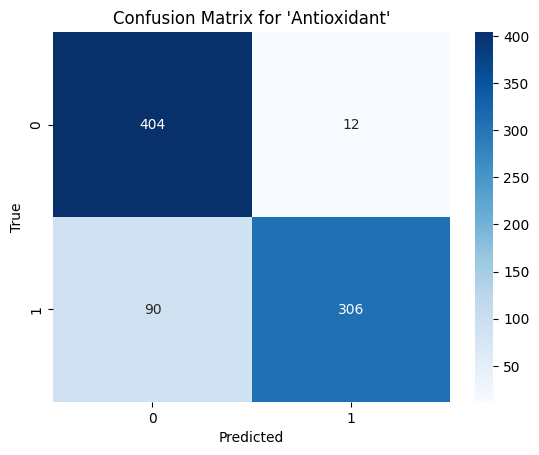

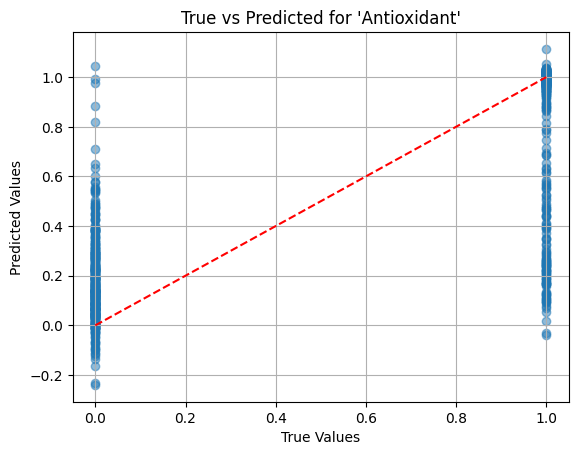


=== Kernel Ridge Regression with RepeatedKFold + RandomizedSearchCV for 'Anti-inflammatory' ===
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best parameters: {'model__gamma': 0.01, 'model__alpha': 0.1}
Optimized threshold: 0.463
ROC AUC: 0.948
Accuracy (thresholded): 0.889
F1 Score (thresholded): 0.883
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89       419
           1       0.90      0.86      0.88       393

    accuracy                           0.89       812
   macro avg       0.89      0.89      0.89       812
weighted avg       0.89      0.89      0.89       812

R² Score: 0.659
RMSE: 0.292
MAE: 0.164
AAD: 0.164


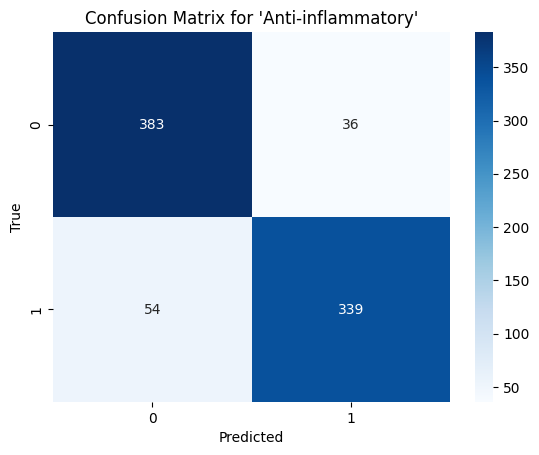

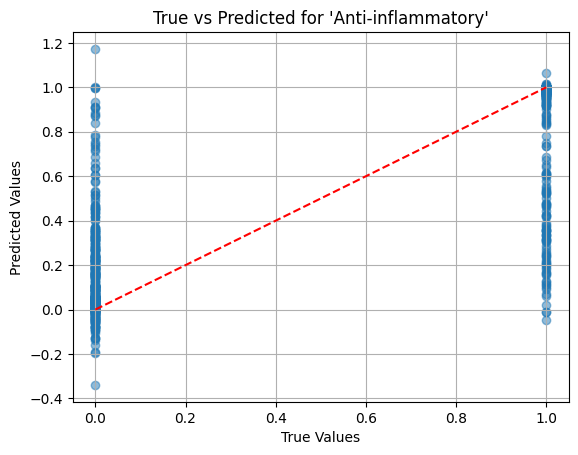


=== Kernel Ridge Regression with RepeatedKFold + RandomizedSearchCV for 'Toxic' ===
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best parameters: {'model__gamma': 0.01, 'model__alpha': 0.1}
Optimized threshold: 0.484
ROC AUC: 0.944
Accuracy (thresholded): 0.887
F1 Score (thresholded): 0.889
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.84      0.88       417
           1       0.85      0.93      0.89       395

    accuracy                           0.89       812
   macro avg       0.89      0.89      0.89       812
weighted avg       0.89      0.89      0.89       812

R² Score: 0.641
RMSE: 0.300
MAE: 0.177
AAD: 0.177


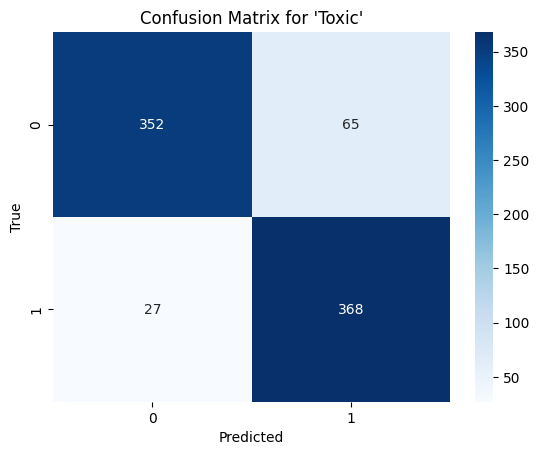

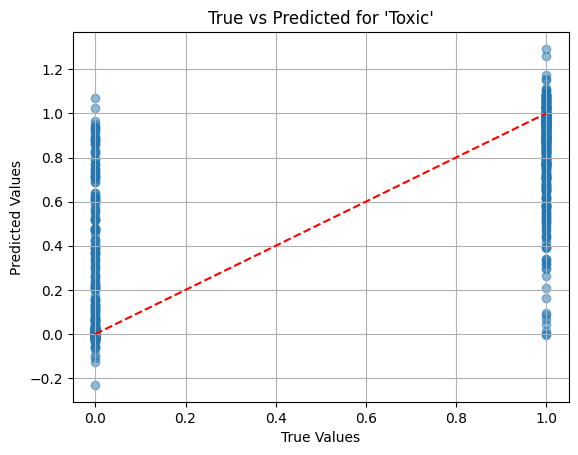

In [ ]:
# Load dataset
df = pd.read_csv("/content/QSAR-QSPR Finalized Dataset.csv")
smiles_list = df["SMILES"].tolist()

# Generate Morgan fingerprints
generator = GetMorganGenerator(radius=2, fpSize=2048)
fps = []
for smi in smiles_list:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        fp = generator.GetFingerprint(mol)
        arr = np.zeros((2048,), dtype=int)
        ConvertToNumpyArray(fp, arr)
        fps.append(arr)
    else:
        fps.append(np.zeros((2048,), dtype=int))

fingerprint_df = pd.DataFrame(fps, columns=[f'FP_{i}' for i in range(2048)])

# Drop SMILES-related columns
df = df.drop(columns=["SMILES", "IUPAC_NAME", "NAME"])

# Define target columns
target_cols = ['Antioxidant', 'Anti-inflammatory', 'Toxic']
df[target_cols] = df[target_cols].astype(int)

# Combine descriptors and fingerprints
descriptor_features = df.drop(columns=target_cols).select_dtypes(include='number')
features = pd.concat([descriptor_features, fingerprint_df], axis=1)

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Loop over each target
for target in target_cols:
    print(f"\n=== Kernel Ridge Regression with RepeatedKFold + RandomizedSearchCV for '{target}' ===")

    y = df[target]

    # Split: 80% train+val, 20% test
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        features_scaled, y, test_size=0.2, random_state=42, stratify=y
    )

    # Define pipeline
    pipe = Pipeline([
        ('select', SelectKBest(score_func=mutual_info_regression, k=100)),
        ('model', KernelRidge(kernel='rbf'))
    ])

    # Parameter grid (adjust as needed)
    param_distributions = {
        'model__alpha': [0.001, 0.01, 0.1],
        'model__gamma': [0.001, 0.01]
    }

    # KFold (regression = no need for stratification)
    rkf = RepeatedKFold(n_splits=4, n_repeats=1, random_state=42)

    # RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions,
        n_iter=4,
        cv=rkf,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    # Fit model using internal CV
    random_search.fit(X_trainval, y_trainval)
    best_model = random_search.best_estimator_
    print(f"Best parameters: {random_search.best_params_}")

    # Predict on test set (pipeline handles transform)
    y_pred = best_model.predict(X_test)

    # Threshold optimization
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    best_threshold = thresholds[np.argmax(f1_scores)]
    y_pred_class = (y_pred >= best_threshold).astype(int)
    print(f"Optimized threshold: {best_threshold:.3f}")

    # Classification metrics
    acc = accuracy_score(y_test, y_pred_class)
    f1 = f1_score(y_test, y_pred_class)
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"ROC AUC: {roc_auc:.3f}")
    print(f"Accuracy (thresholded): {acc:.3f}")
    print(f"F1 Score (thresholded): {f1:.3f}")
    print("Classification Report:\n", classification_report(y_test, y_pred_class))

    # Regression metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    aad = np.mean(np.abs(y_test - y_pred))  # AAD
    print(f"R² Score: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"AAD: {aad:.3f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_class)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for '{target}'")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Scatter plot
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"True vs Predicted for '{target}'")
    plt.grid(True)
    plt.show()

